In [1]:
import gzip

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt

# Preprocessing

## Meta data

In [2]:
def read_geo_series_matrix(file_path):
    cols = {}
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if line.startswith("!Sample_title"):
                sampleId = [i.strip('"') for i in line.split()[1:]]
                cols["sampleId"] = sampleId
            elif line.startswith("!Sample_characteristics_ch1"):
                _ = line[28:].strip().strip('"').split('"\t"')
                category = _[0].split(": ")[0].replace(" ", "_")
                values = [i.split(": ")[1] for i in _]
                cols.update({category: values})
    
    return pd.DataFrame(cols)

In [3]:
meta = read_geo_series_matrix("../rawData/GSE49711_series_matrix.txt.gz")
meta.index = meta.sampleId
meta.shape

(498, 11)

In [4]:
meta = meta.loc[meta.death_from_disease.isin(["0", "1"])]
meta.shape

(498, 11)

In [5]:
pd.crosstab(meta.inss_stage, meta.death_from_disease)

death_from_disease,0,1
inss_stage,,
1,120,1
2,74,4
3,49,14
4,101,82
4S,49,4


In [6]:
pd.crosstab(meta.high_risk, meta.death_from_disease)

death_from_disease,0,1
high_risk,,
0,309,13
1,84,92


In [7]:
meta.Sex.replace({"M":1, "F":0}, inplace=True)
meta.replace({"N/A":np.nan}, inplace=True)

In [8]:
stage_dummy = pd.get_dummies(meta.inss_stage, prefix='inss_stage')
meta = pd.concat([meta, stage_dummy], axis=1)

In [9]:
meta = meta[["Sex", "age_at_diagnosis", "high_risk", 
               "death_from_disease"
              ]]

In [10]:
meta.dropna(inplace=True)

In [11]:
meta = meta.astype("double")

In [12]:
meta.head()

,Sex,age_at_diagnosis,high_risk,death_from_disease
sampleId,,,,
SEQC_NB001,1.0,987.0,1.0,1.0
SEQC_NB002,1.0,1808.0,1.0,1.0
SEQC_NB003,0.0,625.0,1.0,1.0
SEQC_NB004,0.0,335.0,1.0,0.0
SEQC_NB005,0.0,536.0,1.0,1.0


## Gene level

In [13]:
rna = pd.read_table("../rawData/GSE49711_SEQC_NB_TAV_G_log2.final.txt.gz")
rna = rna[~ rna.Gene.str.contains("[a-z]")]
rna.drop(["Gene_set","NCBI_gene_ID","RefSeq_transcript_ID","Chromosome","Strand","Start","End"], axis=1, inplace=True)
X = rna.iloc[:,1:].transpose()
X.columns = rna.Gene

In [14]:
X = X.loc[meta.index] # keep only samples with valid Ys

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, meta.death_from_disease.astype("int"), test_size=0.3, random_state=1234)

# QC

<Axes: >

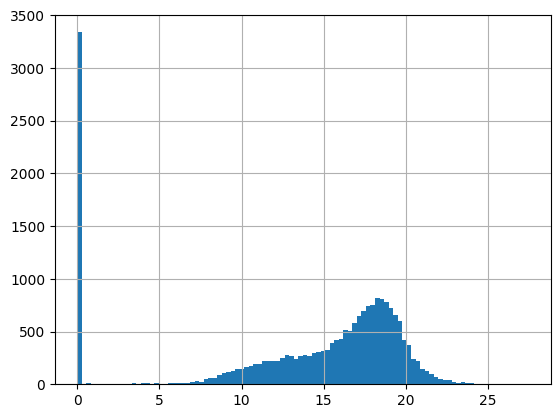

In [16]:
X_train.median().hist(bins=100)

In [17]:
X_train = X_train.loc[:, X_train.median() > 5]

In [18]:
X_train.shape

(348, 17690)

In [19]:
X_train

Gene,A1BGAS,A2BP1,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sampleId,,,,,,,,,,,,,,,,,,,,,
SEQC_NB102,16.7357,17.9114,14.0537,21.9081,0.0000,12.0024,15.6537,9.0301,19.4758,18.0972,...,18.3833,17.6296,14.6009,16.2632,17.9572,7.7186,19.4822,20.7294,19.3656,18.1493
SEQC_NB224,17.5139,11.3959,16.5787,20.2727,0.0000,13.5738,13.7903,10.9309,19.1799,18.4042,...,19.5266,18.6532,14.6978,16.0329,17.8711,11.2946,19.6499,21.4965,18.4547,17.7847
SEQC_NB421,16.0350,20.0305,13.1467,21.5514,12.1984,10.5201,15.0216,0.0000,20.5388,18.2440,...,18.4143,19.8538,13.4772,14.9664,18.8289,0.0000,19.3372,20.5858,19.0560,18.6560
SEQC_NB034,17.6475,18.7384,15.4725,21.1799,12.8712,10.0195,14.7543,10.4171,19.4232,17.7432,...,18.0296,17.4029,15.5527,16.9900,18.2565,11.7547,19.8198,20.4625,18.8839,18.4661
SEQC_NB141,16.9045,19.1381,14.7052,20.6958,0.0000,10.2827,15.6099,10.0843,19.5975,18.1687,...,18.0212,18.8623,14.7029,16.0657,18.3429,0.0000,19.7591,19.9604,19.5410,19.1973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQC_NB205,16.5643,19.4674,14.5277,22.6085,0.0000,11.3414,15.4838,0.0000,19.7447,18.5969,...,18.4851,18.7221,13.5734,15.1146,18.6445,8.8280,19.6722,20.8143,18.3852,18.4585
SEQC_NB054,16.6492,19.5313,14.2535,21.6060,13.1517,12.1404,15.4274,11.4453,19.8313,18.5733,...,17.4503,17.9483,15.2092,17.0717,18.2799,10.3980,20.3791,19.9456,19.6730,18.9018
SEQC_NB295,17.2579,18.9859,15.1080,24.1130,11.6267,0.0000,13.5970,13.6984,19.9612,18.0283,...,18.2514,18.3063,15.1859,16.6240,18.7040,12.1890,19.1276,18.4553,18.9061,18.7622


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [21]:
X_test_scaled = scaler.transform(X_test.loc[:, X_train.columns])
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_train.columns)

In [22]:
meta_train = meta.loc[X_train.index]
age_scaler = StandardScaler()
age_at_diagnosis = age_scaler.fit_transform(np.array(meta_train.age_at_diagnosis).reshape(-1, 1))
meta_train.age_at_diagnosis = age_at_diagnosis
meta_train.drop(["death_from_disease", "high_risk"], axis = 1, inplace=True)

In [23]:
X_train_scaled = pd.concat([X_train_scaled, meta_train], axis=1)

In [24]:
meta_test = meta.loc[X_test.index]
age_at_diagnosis = age_scaler.transform(np.array(meta_test.age_at_diagnosis).reshape(-1, 1))
meta_test.age_at_diagnosis = age_at_diagnosis
meta_test.drop(["death_from_disease", "high_risk"], axis = 1, inplace=True)

In [25]:
X_test_scaled = pd.concat([X_test_scaled, meta_test], axis=1)

# L1 Logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report

In [27]:
model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv = 5, random_state=1234, Cs= 20, class_weight="balanced")
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

In [28]:
accuracy

0.7933333333333333

In [29]:
pd.crosstab(y_pred, y_test)

death_from_disease,0,1
row_0,,
0,98,6
1,25,21


In [30]:
pd.crosstab(meta.loc[y_test.index].high_risk, meta.loc[y_test.index].death_from_disease)

death_from_disease,0.0,1.0
high_risk,,
0.0,100,6
1.0,23,21


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86       123
           1       0.46      0.78      0.58        27

    accuracy                           0.79       150
   macro avg       0.70      0.79      0.72       150
weighted avg       0.85      0.79      0.81       150



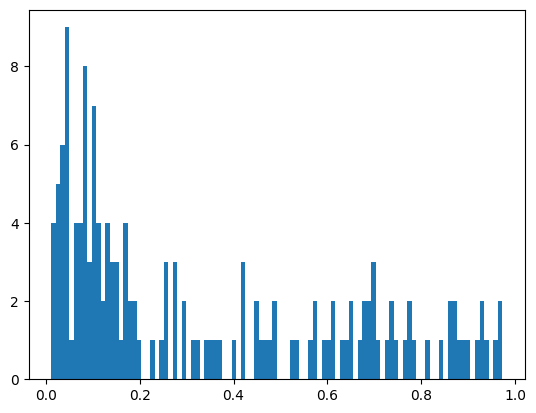

In [32]:
_ = plt.hist(model.predict_proba(X_test_scaled)[:,1], 100)

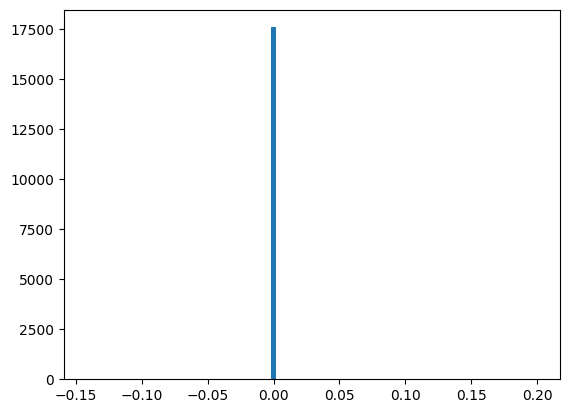

In [33]:
_ = plt.hist(model.coef_[0], 100)

In [34]:
sum(model.coef_[0] != 0)

84

In [35]:
indices = np.argsort(model.coef_[0])[::-1]

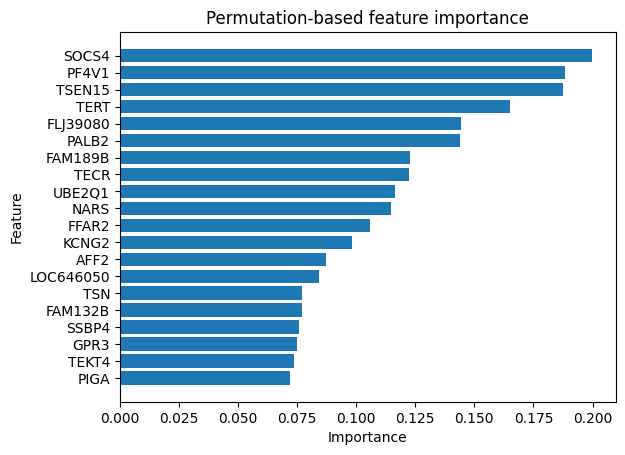

In [36]:
plt.barh(X_train_scaled.columns[indices][range(20)][::-1], model.coef_[0][indices][range(20)][::-1])
plt.title("Permutation-based feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

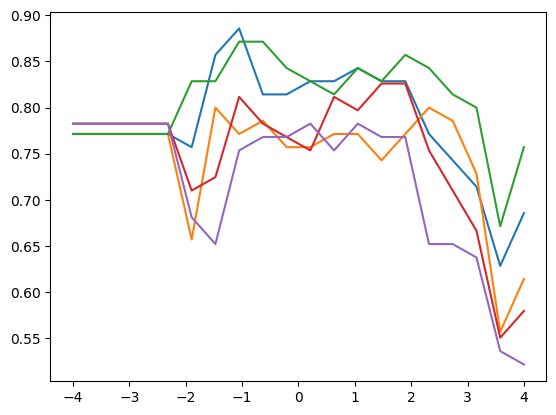

In [37]:
plt.plot(np.log10(model.Cs_), model.scores_[1].T)
plt.show()

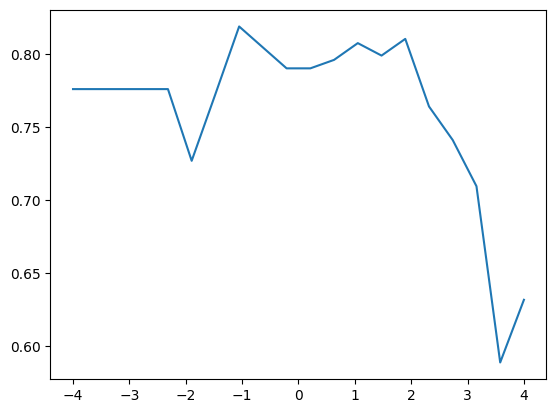

In [38]:
plt.plot(np.log10(model.Cs_), np.mean(model.scores_[1].T, axis = 1))
plt.show()

# Ranodm forest

In [39]:
from sklearn.ensemble import RandomForestClassifier


In [40]:
X_train = pd.concat([X_train, meta_train], axis=1)
X_test = pd.concat([X_test, meta_test], axis=1)

In [41]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=1234, class_weight="balanced")
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test.loc[:, X_train.columns])

In [42]:
accuracy = accuracy_score(y_test, y_pred)

In [43]:
accuracy

0.8533333333333334

In [44]:
pd.crosstab(y_pred, y_test)

death_from_disease,0,1
row_0,,
0,118,17
1,5,10


In [45]:
pd.crosstab(meta.loc[y_test.index].high_risk, meta.loc[y_test.index].death_from_disease)

death_from_disease,0.0,1.0
high_risk,,
0.0,100,6
1.0,23,21


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       123
           1       0.67      0.37      0.48        27

    accuracy                           0.85       150
   macro avg       0.77      0.66      0.70       150
weighted avg       0.84      0.85      0.84       150



In [47]:
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

In [48]:
# Print the feature ranking
print("Feature ranking:")
for f in range(20):
    print("%d. %s: feature %d (%f)" % (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))

Feature ranking:
1. PGM2L1: feature 11439 (0.006877)
2. CNIH4: feature 2467 (0.006185)
3. PHLDB1: feature 11491 (0.005247)
4. LOC100288145: feature 7822 (0.003988)
5. AGRN: feature 356 (0.003877)
6. MRPL11: feature 9861 (0.003876)
7. TMCO1: feature 15639 (0.003292)
8. NPM1P9: feature 10641 (0.003098)
9. LOC653447: feature 8785 (0.002993)
10. CCDC86: feature 1788 (0.002982)
11. ELK1: feature 3802 (0.002970)
12. BAZ2B: feature 1204 (0.002949)
13. LOC644390: feature 8622 (0.002860)
14. SLBP: feature 14191 (0.002854)
15. POLE3: feature 11807 (0.002838)
16. HNRNPC: feature 6014 (0.002730)
17. SNRPE: feature 14662 (0.002684)
18. GAR1: feature 5062 (0.002622)
19. HSD17B3: feature 6115 (0.002495)
20. NUP37: feature 10811 (0.002439)


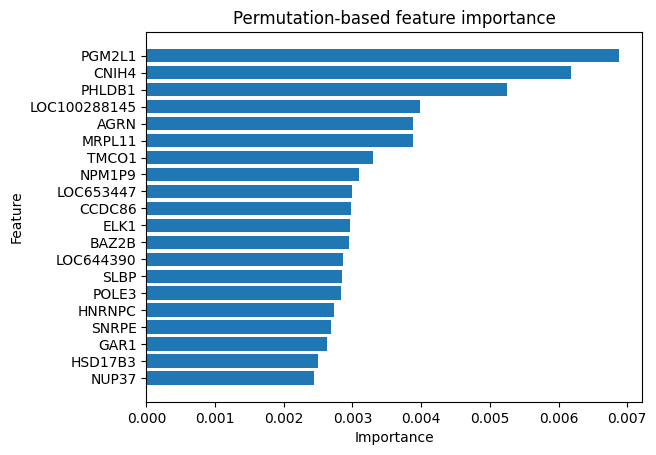

In [49]:
plt.barh(X_train.columns[indices][range(20)][::-1], importances[indices][range(20)][::-1])
plt.title("Permutation-based feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()